In [27]:
import sys
import math
import numpy as np
import time
from scipy import stats
from scipy.spatial import distance
import matplotlib.pyplot as plt
sys.setrecursionlimit(1500)

In [2]:
# convert input txt into an 140000 * 28 array
def inputDigit(img_dir="digitdata/trainingimages"):
    with open(img_dir) as digitTxt:
        image = [list(line)[0:28] for line in digitTxt]
        rows = len(image)
        
    for i in range(rows):
        for j in range(28):
            if image[i][j] == ' ':
                image[i][j] = 0
            else:
                image[i][j] = 1
    return image

In [3]:
def unrollImg(img):
    image_num = int(len(img)/28)     #each img consists of 28 lines
    unrolledImg = [[] for x in range(image_num)]          # 500*784
    offset = 0
    for i in range(image_num):  # i: 0--500
        for j in range(28):   # j: 0--28  roll num in rolled img
            unrolledImg[i] += img[offset+j]
        offset +=28

    return np.array(unrolledImg)

In [4]:
def readLabel(name="digitdata/traininglabels"):
    with open(name) as label:
        labels = []
        for line in label:
            labels.append(int(line[0]))
    return labels

In [5]:
trainingImg = inputDigit("digitdata/trainingimages")
np_train_img = unrollImg(trainingImg)
trainingLabel = readLabel("digitdata/traininglabels")
testImg = inputDigit("digitdata/testimages")
np_test_img = unrollImg(testImg)
testLabel = readLabel("digitdata/testlabels")

In [6]:
def conf_matrix(trueLabel, predLabel):
    cm = np.zeros((10,10))
    overall_acc = 0
    for i in range(len(trueLabel)):
        cm[int(trueLabel[i])][int(predLabel[i])] += 1
    total_sample_size = np.sum(cm)
    for i in range(10):
        cur_row_sum = np.sum(cm[i])
        cm[i] /= cur_row_sum
        overall_acc += cm[i][i]*cur_row_sum/total_sample_size
    return cm, overall_acc

In [7]:
def keep_k_digits(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            matrix[i][j] = float(format(matrix[i][j], '.4f'))
    return matrix

In [8]:
def euclidean_distance(testfeat, trainfeat):
    test_num = testfeat.shape[0]
    train_num = trainfeat.shape[0]
    img_size = testfeat.shape[1]
    dist_matrix = np.zeros((test_num, train_num)) # this should be 1000 x 5000
    for i in range(test_num):
        print(i)
        for j in range(train_num):
            #diff_square_sum = 0
            diff_list = np.zeros(img_size)
            for p in range(img_size):
                diff_list[p] = testfeat[i][p] - trainfeat[j][p]
            
            dist_matrix[i][j] = np.sum(np.square(diff_list))
    dist_matrix = np.sqrt(dist_matrix)
    return dist_matrix

In [9]:
def kNN(trainfeat, trainlabel, testfeat, dist_matrix, k=4):
    #Put your code here
    trainlabel = np.array(trainlabel)
    estimatedLabel = np.zeros(testfeat.shape[0])
    #nearest = euclidean_distance(testfeat, trainfeat)  #this is a matrix of distance between test points and train points
    for i in range(testfeat.shape[0]):
        nearestPoints = dist_matrix[i]         #here we got an array holding the distances between the test point and all the train point 
        nearestKLabels= trainlabel[np.argpartition(nearestPoints, k)[0:k]]   #got the smallest k distances' index, and get their labels
        estimatedLabel[i] = stats.mode(nearestKLabels)[0][0] #mode[0] gives us the mode result array, and mode[0][0] gives us the result
    return np.array(estimatedLabel)

In [25]:
#euc_dist_matrix = distance.cdist(np_test_img, np_train_img, 'euclidean')
sin_dist_matrix = distance.cdist(np_test_img, np_train_img, 'cosine')
#sin_dist_matrix = distance.cdist(np_test_img, np_train_img, 'minkowski', p=1.)
#euc_dist_matrix = euclidean_distance(np_test_img, np_train_img)

In [21]:
predLabel = kNN(np_train_img, trainingLabel, np_test_img, sin_dist_matrix, 4)
#print(predLabel)

In [22]:
cm, overall_acc = conf_matrix(testLabel, predLabel)
cm = keep_k_digits(cm)
print(overall_acc)
print(cm)

0.91
[[ 1.      0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      1.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.0097  0.0291  0.932   0.0194  0.      0.      0.      0.0097  0.      0.    ]
 [ 0.      0.01    0.01    0.89    0.      0.02    0.      0.03    0.03
   0.01  ]
 [ 0.      0.0093  0.      0.      0.9533  0.      0.0187  0.0093  0.
   0.0093]
 [ 0.0217  0.0109  0.      0.0543  0.0109  0.8478  0.0326  0.0109  0.0109
   0.    ]
 [ 0.      0.011   0.      0.      0.011   0.011   0.967   0.      0.      0.    ]
 [ 0.      0.0849  0.0094  0.      0.0189  0.      0.      0.8585  0.
   0.0283]
 [ 0.0194  0.0291  0.      0.0485  0.0388  0.0485  0.      0.0194  0.7767
   0.0194]
 [ 0.      0.      0.      0.04    0.04    0.01    0.      0.03    0.      0.88  ]]


In [32]:
start = time.time()
one = kNN(np_train_img, trainingLabel, np_test_img, sin_dist_matrix, 1)
end = time.time()
print("1 NN takes", end-start, "seconds")
start = time.time()
two = kNN(np_train_img, trainingLabel, np_test_img,sin_dist_matrix, 2)
end = time.time()
print("2 NN takes", end-start, "seconds")
start = time.time()
three = kNN(np_train_img, trainingLabel, np_test_img, sin_dist_matrix, 3)
end = time.time()
print("3 NN takes", end-start, "seconds")
start = time.time()
four = kNN(np_train_img, trainingLabel, np_test_img, sin_dist_matrix, 4)
end = time.time()
print("4 NN takes", end-start, "seconds")
start = time.time()
five = kNN(np_train_img, trainingLabel, np_test_img, sin_dist_matrix, 5)
end = time.time()
print("5 NN takes", end-start, "seconds")
start = time.time()
six = kNN(np_train_img, trainingLabel, np_test_img, sin_dist_matrix, 6)
end = time.time()
print("6 NN takes", end-start, "seconds")
start = time.time()
seven = kNN(np_train_img, trainingLabel, np_test_img, sin_dist_matrix, 7)
end = time.time()
print("7 NN takes", end-start, "seconds")
start = time.time()
eight = kNN(np_train_img, trainingLabel, np_test_img, sin_dist_matrix, 8)
end = time.time()
print("8 NN takes", end-start, "seconds")

_, one_acc = conf_matrix(testLabel, one)
_, two_acc = conf_matrix(testLabel, two)
_, three_acc = conf_matrix(testLabel, three)
_, four_acc = conf_matrix(testLabel, four)
_, five_acc = conf_matrix(testLabel, five)
_, six_acc = conf_matrix(testLabel, six)
_, seven_acc = conf_matrix(testLabel, seven)
_, eight_acc = conf_matrix(testLabel, eight)

1 NN takes 0.09206295013427734 seconds
2 NN takes 0.08700895309448242 seconds
3 NN takes 0.14609193801879883 seconds
4 NN takes 0.1822190284729004 seconds
5 NN takes 0.17010879516601562 seconds
6 NN takes 0.13198304176330566 seconds
7 NN takes 0.1421513557434082 seconds
8 NN takes 0.12399649620056152 seconds


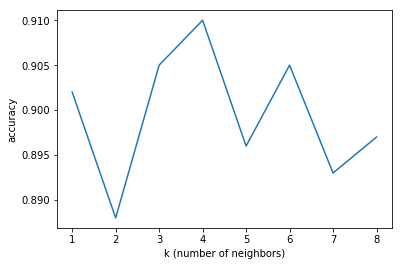

In [24]:
x = [1, 2, 3, 4, 5, 6, 7, 8]
y = []
plt.xlabel('k (number of neighbors)')
plt.ylabel('accuracy')
y.append(one_acc)
y.append(two_acc)
y.append(three_acc)
y.append(four_acc)
y.append(five_acc)
y.append(six_acc)
y.append(seven_acc)
y.append(eight_acc)
plt.plot(x, y)
plt.show()